This is a sample notebook for TP2 in pytorch, corresponding to <code>tgabor.py</code>.<br>
This is a "Markdown" (comment) cell. Double click on it to see the source code. Click on run while selected to see it formatted.<br>

Below is a "Code cell". Click on "Run" to execute it.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import math
import time

import matplotlib.pyplot as plt
import numpy as np

ImportError: cannot import name 'COMMON_SAFE_ASCII_CHARACTERS' from 'charset_normalizer.constant' (/Users/fabienbehra/opt/anaconda3/envs/env_pytorch/lib/python3.9/site-packages/charset_normalizer/constant.py)

Here we check whether a GPU is available.<br>
You may comment or uncomment the second line to run with or withou a GPU.<br>
You will need to re-run all the cells after this one to see the difference.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


The next two cells contain two versions of the same kernel initialization function.<br>
The first one uses sequential loops while the second one uses parallel tensor operations.<br>
This function corresponds to eight calls to the TP2 <code>gabor_kernel()</code> function, each corresponding to a different orientation but to a signle wavelength. It only has to be called four times, one for each wavelength.<br>
Unlike in <code>TP2 gabor_kernel()</code>, the result is not a 2D array of complex numbers, it is a 3D array of real numbers. The third dimension is $2\times8=16$. Real parts are in feature maps 0 to 7 and imaginary parts are in feature maps 8 to 15.<br>
Both functions include execution time measurement.

In [3]:
def gabor_kernel_init_seq(weight,lambd = 16.0, nt = 8, n = 0, sl = 0.7, st = 1.4, nl = 4.0):
    if torch.cuda.is_available(): torch.cuda.synchronize()
    t0 = time.time()
    if n <= 0: n = 1+2*int(nl*lambd)
    gl = -0.5/(sl*sl)  # lambda direction scale factor
    gt = -0.5/(st*st)  # theta direction scale factor
    for t in range (0, nt):
        theta = t*math.pi/nt  # orientation
        c = math.cos(theta)/lambd  # rotation and scaling
        s = math.sin(theta)/lambd  # parameters
        x0 = 0.5*(n-1)*(c+s)  # translation
        y0 = 0.5*(n-1)*(c-s)  # parameters
        sc = 1.0/(2*math.pi*sl*st*lambd*lambd)  # Gaussian normalization factor
        for y in range (0,n):
            for x in range (0,n):
                xr = c*x+s*y-x0  # centering, rotation and scaling
                yr = c*y-s*x-y0  # centering, rotation and scaling
                a = 2.0*math.pi*xr  # wave phase
                g = sc*math.exp(gl*xr*xr+gt*yr*yr)  # Gaussian amplitude
                weight[t+0*nt, 0, y, x] = g*math.cos(a)  # real component
                weight[t+1*nt, 0, y, x] = g*math.sin(a)  # imaginary component
    if torch.cuda.is_available(): torch.cuda.synchronize()
    print("kernel init sequential %dx%d: %.2f ms"% (n, n, 1000*(time.time()-t0)))

In [4]:
def gabor_kernel_init(weight,lambd = 16.0, nt = 8, n = 0, sl = 0.7, st = 1.4, nl = 4.0):
    if torch.cuda.is_available(): torch.cuda.synchronize()
    t0 = time.time()
    if n <= 0: n = 1+2*int(nl*lambd)
    gl = -0.5/(sl*sl)  # lambda direction scale factor
    gt = -0.5/(st*st)  # theta direction scale factor
    x = torch.tensor(range(n)).unsqueeze(0).expand(n,n)  # x coordinate
    y = torch.tensor(range(n)).unsqueeze(1).expand(n,n)  # y coordinate
    for t in range (0, nt):
        theta = t*math.pi/nt  # orientation
        c = math.cos(theta)/lambd  # rotation and scaling
        s = math.sin(theta)/lambd  # parameters
        x0 = 0.5*(n-1)*(c+s)  # translation
        y0 = 0.5*(n-1)*(c-s)  # parameters
        sc = 1.0/(2*math.pi*sl*st*lambd*lambd)  # Gaussian normalization factor
        xr = c*x+s*y-x0  # centering, rotation and scaling
        yr = c*y-s*x-y0  # centering, rotation and scaling
        a = 2.0*math.pi*xr  # wave phase
        g = sc*torch.exp(gl*xr*xr+gt*yr*yr)  # Gaussian amplitude
        weight[t+0*nt, 0] = g*torch.cos(a)  # real component
        weight[t+1*nt, 0] = g*torch.sin(a)  # imaginary component
    if torch.cuda.is_available(): torch.cuda.synchronize()
    print("kernel init %dx%d: %.2f ms"% (n, n, 1000*(time.time()-t0)))

Here, we define the whole Gabor transform computation as a single network.<br>
At this points, the kernels contain random initial values.<br>
There is a set of filters (<code>conv2d()</code>) per wavelength since the size of the fliters depend upon it.<br>
The size of the filters are large compared to typical CNN filters.<br>
<code>F.adaptive_avg_pool2d()</code> does a global average pooling resulting in a $1\times1$ image, hence the need for a squeeze, after which the results can be concatenated.<br>
Unlike in classical convolutional neural networks where convolutions are combined squentially, the convolutions here are computed in parallel and concatenated (after the global pooling and squaring).<br>
The last two lines computes the sum of the "energies" for the real and imaginary parts.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(1, 16, 25, bias=False)
        self.conv1 = nn.Conv2d(1, 16, 49, bias=False)
        self.conv2 = nn.Conv2d(1, 16, 97, bias=False)
        self.conv3 = nn.Conv2d(1, 16, 193, bias=False)
 
    def forward(self, x):
        x0 = torch.squeeze(F.adaptive_avg_pool2d(self.conv0(x)**2, (1, 1)),3)/1
        x1 = torch.squeeze(F.adaptive_avg_pool2d(self.conv1(x)**2, (1, 1)),3)/2
        x2 = torch.squeeze(F.adaptive_avg_pool2d(self.conv2(x)**2, (1, 1)),3)/4
        x3 = torch.squeeze(F.adaptive_avg_pool2d(self.conv3(x)**2, (1, 1)),3)/8
        y = torch.cat((x0, x1, x2, x3), dim = 2)
        y1, y2 = torch.split(y, 8, dim = 1)
        return((y1+y2).transpose(1,2))


Here we do the net instanciation and initialization.<br>
If a GPU is available and selected, the net structure is moved onto it.<br>
Depending upon whether <code>net.to(device)</code> is called at the beginning or at the end, the filter initialization is done on the GPU or on the CPU. You just need to move the # sign and re-run the cell to see the difference in execution time (comment the <code>device = "cpu"</code> line in the beginning). Not much difference for this.<br>
You may also try to replace <code>gabor_kernel_init()</code> with <code>gabor_kernel_init_seq()</code>. Parallelism significantly improves both on CPU and GPU. Sequential execution on GPU is worse thant on CPU.

In [6]:
net = Net()
net.to(device)
if torch.cuda.is_available(): torch.cuda.synchronize()
t0 = time.time()
gabor_kernel_init(net.conv0.weight,lambd = 3.0) # slower due to initializations
gabor_kernel_init(net.conv0.weight,lambd = 3.0)
gabor_kernel_init(net.conv1.weight,lambd = 6.0)
gabor_kernel_init(net.conv2.weight,lambd = 12.0)
gabor_kernel_init(net.conv3.weight,lambd = 24.0)
if torch.cuda.is_available(): torch.cuda.synchronize()
print("total init time: %.2f ms"% (1000*(time.time()-t0)))
#net.to(device)
print(net)

kernel init 25x25: 2.61 ms
kernel init 25x25: 2.28 ms
kernel init 49x49: 2.33 ms
kernel init 97x97: 3.76 ms
kernel init 193x193: 79.20 ms
total init time: 91.16 ms
Net(
  (conv0): Conv2d(1, 16, kernel_size=(25, 25), stride=(1, 1), bias=False)
  (conv1): Conv2d(1, 16, kernel_size=(49, 49), stride=(1, 1), bias=False)
  (conv2): Conv2d(1, 16, kernel_size=(97, 97), stride=(1, 1), bias=False)
  (conv3): Conv2d(1, 16, kernel_size=(193, 193), stride=(1, 1), bias=False)
)


Visualize the kernels in the following four cells, each corresponding to a scale (wavelength). Though the kernels look similar at all scales, each is twice as big as the previous one, as can bee seen from the scale in pixels of the displayed kernels. The top row correspond to the real part and the bottopn row corresponds to ihe imaginary part. Columns correspond to orientations.

torch.Size([16, 1, 25, 25])


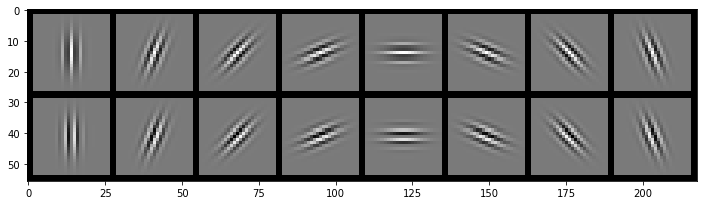

In [7]:
plt.rcParams["figure.figsize"] = (12,6)
k0 = list(net.parameters())[0]
print(k0.shape)
p = torchvision.utils.make_grid(k0, padding = 2, normalize = True)
plt.imshow(np.transpose(p.to("cpu").detach().numpy(), (1, 2, 0)))

torch.Size([16, 1, 49, 49])


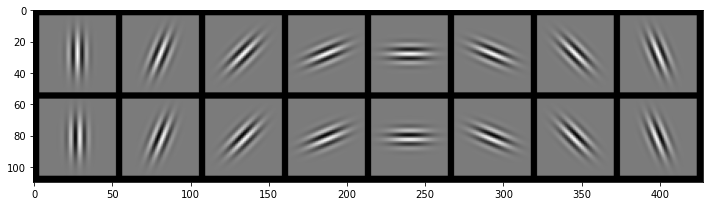

In [8]:
k1 = list(net.parameters())[1]
print(k1.shape)
p = torchvision.utils.make_grid(k1, padding = 4, normalize = True)
plt.imshow(np.transpose(p.to("cpu").detach().numpy(), (1, 2, 0)))

torch.Size([16, 1, 97, 97])


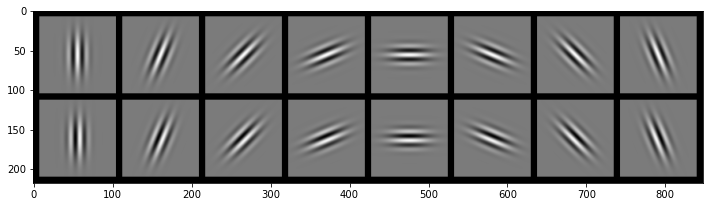

In [9]:
k2 = list(net.parameters())[2]
print(k2.shape)
p = torchvision.utils.make_grid(k2, padding = 8, normalize = True)
plt.imshow(np.transpose(p.to("cpu").detach().numpy(), (1, 2, 0)))

torch.Size([16, 1, 193, 193])


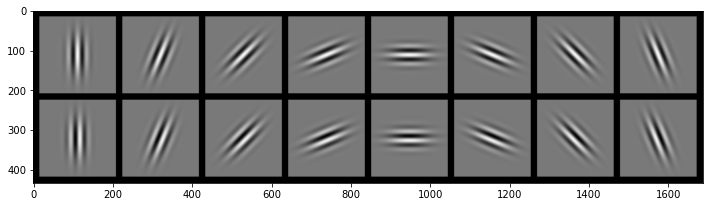

In [10]:
k3 = list(net.parameters())[3]
print(k3.shape)
p = torchvision.utils.make_grid(k3, padding = 16, normalize = True)
plt.imshow(np.transpose(p.to("cpu").detach().numpy(), (1, 2, 0)))

Read 4 images, make a batch from them and send them to device.<br>
Or create a random batch of arbitrary size for computation performance evaluation.

torch.Size([4, 1, 256, 256])


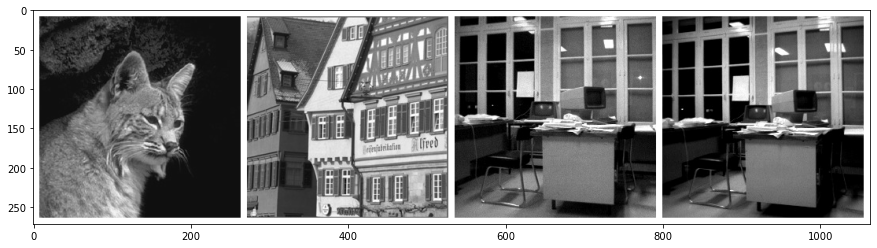

In [11]:
from PIL import Image
import torchvision.transforms.functional as TF
x = torch.cat((255*TF.to_tensor(Image.open('cat.jpg')).unsqueeze(0),
               255*TF.to_tensor(Image.open('houses.jpg')).unsqueeze(0),
               255*TF.to_tensor(Image.open('bur0.jpg')).unsqueeze(0),
               255*TF.to_tensor(Image.open('bur1.jpg')).unsqueeze(0))).to(device)

plt.rcParams["figure.figsize"] = (15,8)
gx = torchvision.utils.make_grid(x, padding = 8, normalize = True, pad_value = 1)
plt.imshow(np.transpose(gx.to("cpu").detach().numpy(), (1, 2, 0)))

b = 4
#x = torch.randn(b,1,256,256).to(device)
print(x.shape)

Compute the number of floating point operations per image: one addition and one multiplication per output pixel, per kernel element for each filter and at all resolutions (cropping taken into account).

In [12]:
nops = ((64.0*64*193*193)+(160.0*160*97*97)+(208.0*208*49*49)+(232*232*25*25))*16.0*2.0
print("Gflops/image: %.3f"% (nops/1000000000.0))

Gflops/image: 16.991


Run several times to get statistics on execution times. Can be tried on CPU and on GPU. First iterations are slower.

In [13]:
tt = 0
for i in range(20): 
    if torch.cuda.is_available(): torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad(): y = net(x)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    dt = time.time()-t0
    print("iter %2d: %.2f ms, %.3f Tflops"% (i, dt*1000, b*nops/dt/1000000000000))
    if (i > 3): tt += dt

dt = tt/16
print("Average: %.2f ms, %.3f Tflops"% (dt*1000, b*nops/dt/1000000000000))

iter  0: 34.60 ms, 1.964 Tflops
iter  1: 32.01 ms, 2.123 Tflops
iter  2: 31.92 ms, 2.129 Tflops
iter  3: 31.57 ms, 2.152 Tflops
iter  4: 30.93 ms, 2.197 Tflops
iter  5: 31.15 ms, 2.182 Tflops
iter  6: 31.43 ms, 2.162 Tflops
iter  7: 31.80 ms, 2.137 Tflops
iter  8: 32.16 ms, 2.113 Tflops
iter  9: 31.58 ms, 2.152 Tflops
iter 10: 31.77 ms, 2.139 Tflops
iter 11: 32.34 ms, 2.101 Tflops
iter 12: 31.76 ms, 2.140 Tflops
iter 13: 31.36 ms, 2.167 Tflops
iter 14: 31.85 ms, 2.134 Tflops
iter 15: 31.51 ms, 2.157 Tflops
iter 16: 32.04 ms, 2.121 Tflops
iter 17: 32.06 ms, 2.120 Tflops
iter 18: 32.01 ms, 2.123 Tflops
iter 19: 31.97 ms, 2.126 Tflops
Average: 31.73 ms, 2.142 Tflops


Print and plot results. Should be consistent with the numpy / scipy version of TP2.

torch.Size([4, 4, 8])
tensor([[[ 1.0065,  0.8843,  0.9673,  0.9153,  0.9879,  1.1373,  1.0379,
           0.9988],
         [ 0.9149,  0.9327,  1.1381,  1.0138,  1.1274,  1.3426,  1.2645,
           1.3810],
         [ 1.1976,  1.1202,  1.0789,  0.6856,  0.7596,  0.7403,  1.2825,
           1.9464],
         [ 0.7145,  0.3097,  0.8191,  0.7331,  2.3015,  1.2941,  0.6627,
           1.6894]],

        [[19.9091,  4.4179,  1.1953,  3.0932, 10.1122,  1.2978,  0.9888,
           1.8669],
         [22.8977,  3.5579,  1.4379,  3.6866,  9.6574,  1.2347,  1.3890,
           2.3957],
         [ 9.0294,  5.0205,  1.2536,  1.0404,  9.0134,  1.1716,  0.6645,
           1.3802],
         [13.6040,  4.4125,  0.5186,  1.5334,  6.1166,  0.7428,  0.1657,
           2.2692]],

        [[ 6.1645,  0.6255,  0.6519,  1.1414, 10.9845,  1.4242,  0.6019,
           0.5905],
         [15.5254,  0.6862,  0.5434,  1.6851, 14.0147,  1.6827,  0.5797,
           0.7974],
         [11.0596,  0.9496,  0.9229,  2.0302

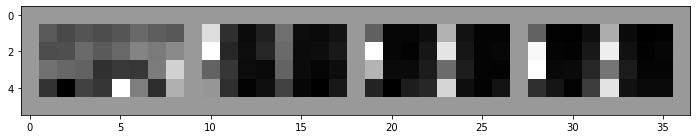

In [14]:
print(y.shape)
print(y)
uy = y.unsqueeze(1)
print(uy.shape)
print(uy)
gy = torchvision.utils.make_grid(uy, padding = 1, normalize = True, scale_each = True, pad_value = 0.60)
npy = np.transpose(gy.to("cpu").detach().numpy(), (1, 2, 0))
plt.rcParams["figure.figsize"] = (12,6)
plt.imshow(npy)
print("\n\n cat, houses, bur0, bur1:")

Use another network to display the images tranformed by the Gabor filters (no global averaging, zero padding).

In [15]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv0 = nn.Conv2d(1, 16, 25, bias=False, padding = 12)
        self.conv1 = nn.Conv2d(1, 16, 49, bias=False, padding = 24)
        self.conv2 = nn.Conv2d(1, 16, 97, bias=False, padding = 48)
        self.conv3 = nn.Conv2d(1, 16, 193, bias=False, padding = 96)
 
    def forward(self, x):
        x0 = (self.conv0(x)**2).unsqueeze(2)/1
        x1 = (self.conv1(x)**2).unsqueeze(2)/2
        x2 = (self.conv2(x)**2).unsqueeze(2)/4
        x3 = (self.conv3(x)**2).unsqueeze(2)/8
        y = torch.cat((x0, x1, x2, x3), dim = 2)
        y1, y2 = torch.split(y, 8, dim = 1)
        return((y1+y2).transpose(1,2))

In [16]:
net2 = Net2()
net2.to(device)
gabor_kernel_init(net2.conv0.weight,lambd = 3.0)
gabor_kernel_init(net2.conv1.weight,lambd = 6.0)
gabor_kernel_init(net2.conv2.weight,lambd = 12.0)
gabor_kernel_init(net2.conv3.weight,lambd = 24.0)
print(net2)

kernel init 25x25: 2.10 ms
kernel init 49x49: 2.46 ms
kernel init 97x97: 3.25 ms
kernel init 193x193: 81.85 ms
Net2(
  (conv0): Conv2d(1, 16, kernel_size=(25, 25), stride=(1, 1), padding=(12, 12), bias=False)
  (conv1): Conv2d(1, 16, kernel_size=(49, 49), stride=(1, 1), padding=(24, 24), bias=False)
  (conv2): Conv2d(1, 16, kernel_size=(97, 97), stride=(1, 1), padding=(48, 48), bias=False)
  (conv3): Conv2d(1, 16, kernel_size=(193, 193), stride=(1, 1), padding=(96, 96), bias=False)
)


In [17]:
with torch.no_grad(): y = net2(x)
print(y.shape)
z = torch.reshape(y, (4, 32, 1, 256, 256))
print(z.shape)

torch.Size([4, 4, 8, 256, 256])
torch.Size([4, 32, 1, 256, 256])


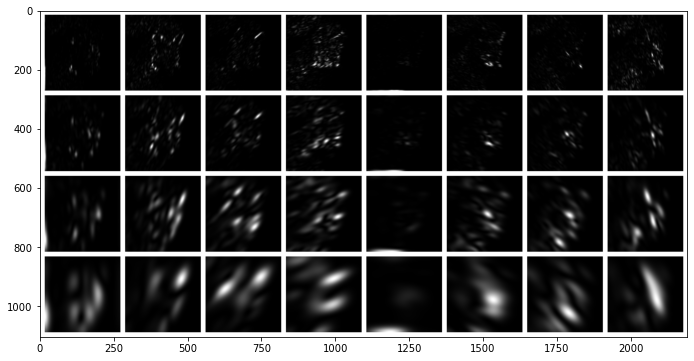

In [18]:
# cat.jpg
gz = torchvision.utils.make_grid(z[0], padding = 16, normalize = True, scale_each = True, pad_value = 1)
plt.imshow(np.transpose(gz.to("cpu").detach().numpy(), (1, 2, 0)))

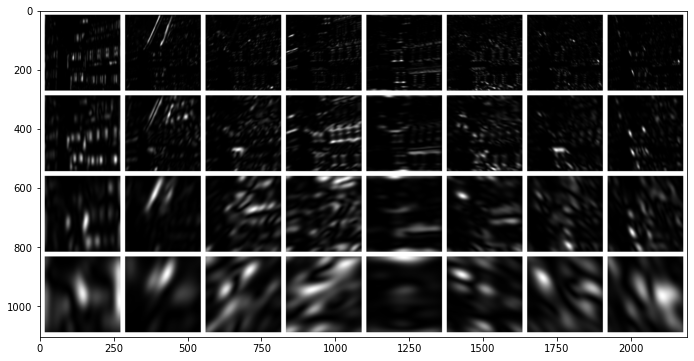

In [19]:
# houses.jpg
gz = torchvision.utils.make_grid(z[1], padding = 16, normalize = True, scale_each = True, pad_value = 1)
plt.imshow(np.transpose(gz.to("cpu").detach().numpy(), (1, 2, 0)))

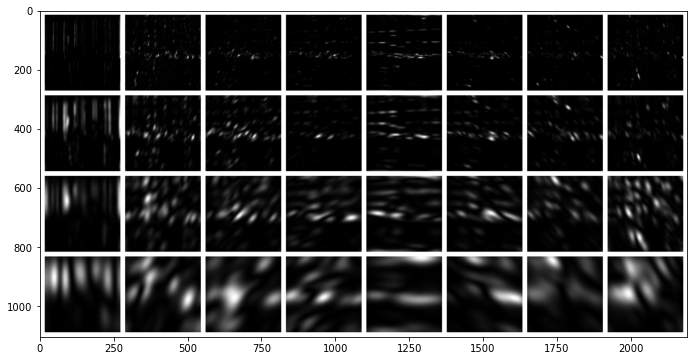

In [20]:
# bur0.jpg
gz = torchvision.utils.make_grid(z[2], padding = 16, normalize = True, scale_each = True, pad_value = 1)
plt.imshow(np.transpose(gz.to("cpu").detach().numpy(), (1, 2, 0)))

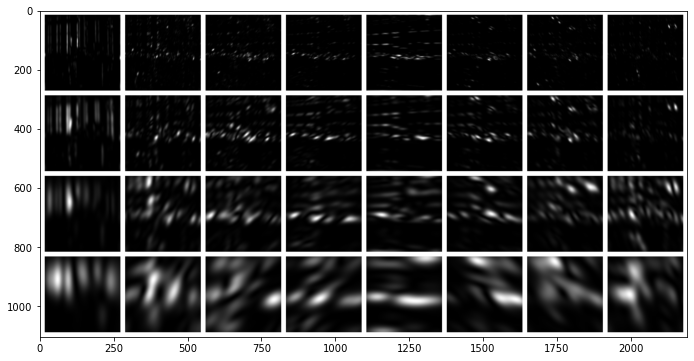

In [21]:
# bur1.jpg
gz = torchvision.utils.make_grid(z[3], padding = 16, normalize = True, scale_each = True, pad_value = 1)
plt.imshow(np.transpose(gz.to("cpu").detach().numpy(), (1, 2, 0)))